# Film Junky Union

## Introduction

### Project Statement

The Film Junky Union, a new and edgy community for classic movie enthusiasts, is creating a system to filter and categorize movie reviews. The objective is to train a model that can automatically identify negative reviews. You will use a dataset of IMDB movie reviews with polarity labels to build a model that classifies reviews as positive or negative. The model must achieve an F1 score of at least 0.85.

## Initialization

### Library Imports

In [1]:
import os
import math
import random 
import re
import spacy
import nltk
import torch
import transformers

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.metrics as metrics

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from torch.utils.data import DataLoader, TensorDataset

from lightgbm import LGBMClassifier

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tqdm.auto import tqdm

### Configurations

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_colwidth', 1000)

plt.style.use('seaborn')

In [3]:
tqdm.pandas()

### Data Import

In [4]:
df_reviews = pd.read_csv('/data/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews = df_reviews.rename(columns={'tconst': 't_const'})

## Data Pre-processing

In [6]:
# Look for missing values

df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   t_const          47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
# Look for missing values

df_reviews.isna().sum()

t_const            0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [8]:
# Drop missing values

df_reviews.dropna(inplace=True)

In [9]:
# Ensure missing values were handled

df_reviews.isna().sum()

t_const            0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

**Findings:**
Since there are only a few missing values, they will be handled by dropping them, as this will not significantly impact the dataset.

In [10]:
# Look for duplicate values

df_reviews.duplicated().value_counts()

False    47329
dtype: int64

**Findings:**
There are no duplicates values within the dataset.

In [11]:
# Replace defined missing value in end_year with a clearer value

df_reviews['end_year'] = df_reviews['end_year'].replace('\\N', "n/a")

## EDA

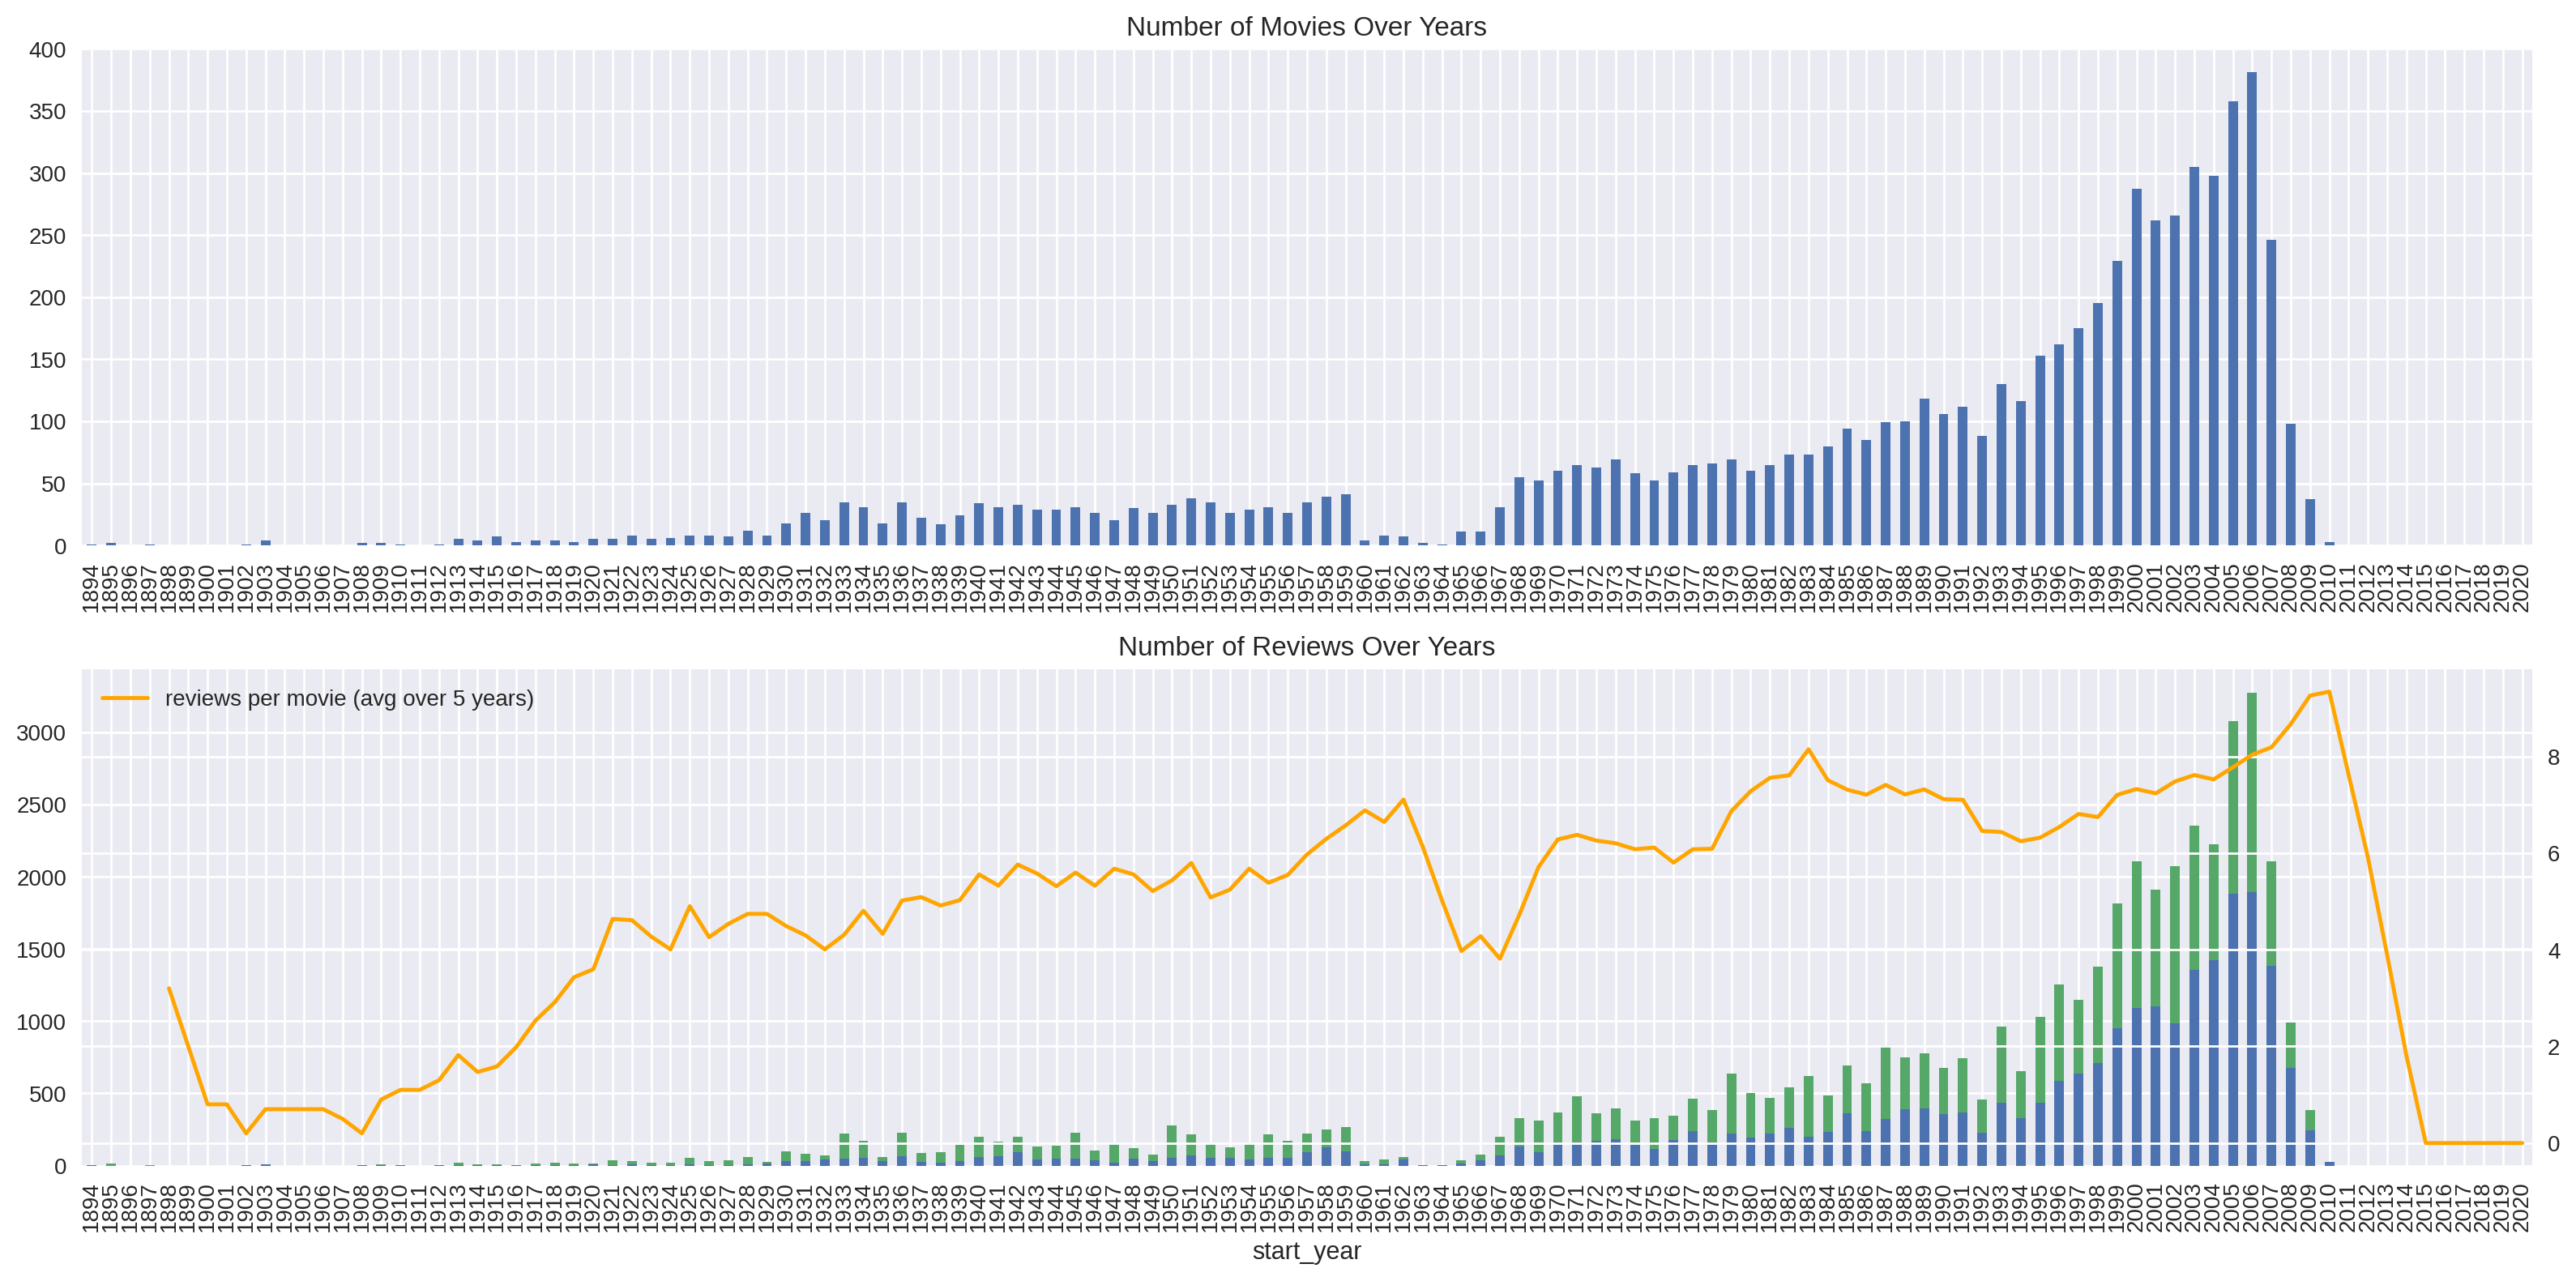

In [12]:
# Check number of reviews over the years

fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['t_const', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

**Observations:**

The number of movie reviews increased over time, likely due to the advent of the internet, which enabled people to share movie reviews faster and more frequently.

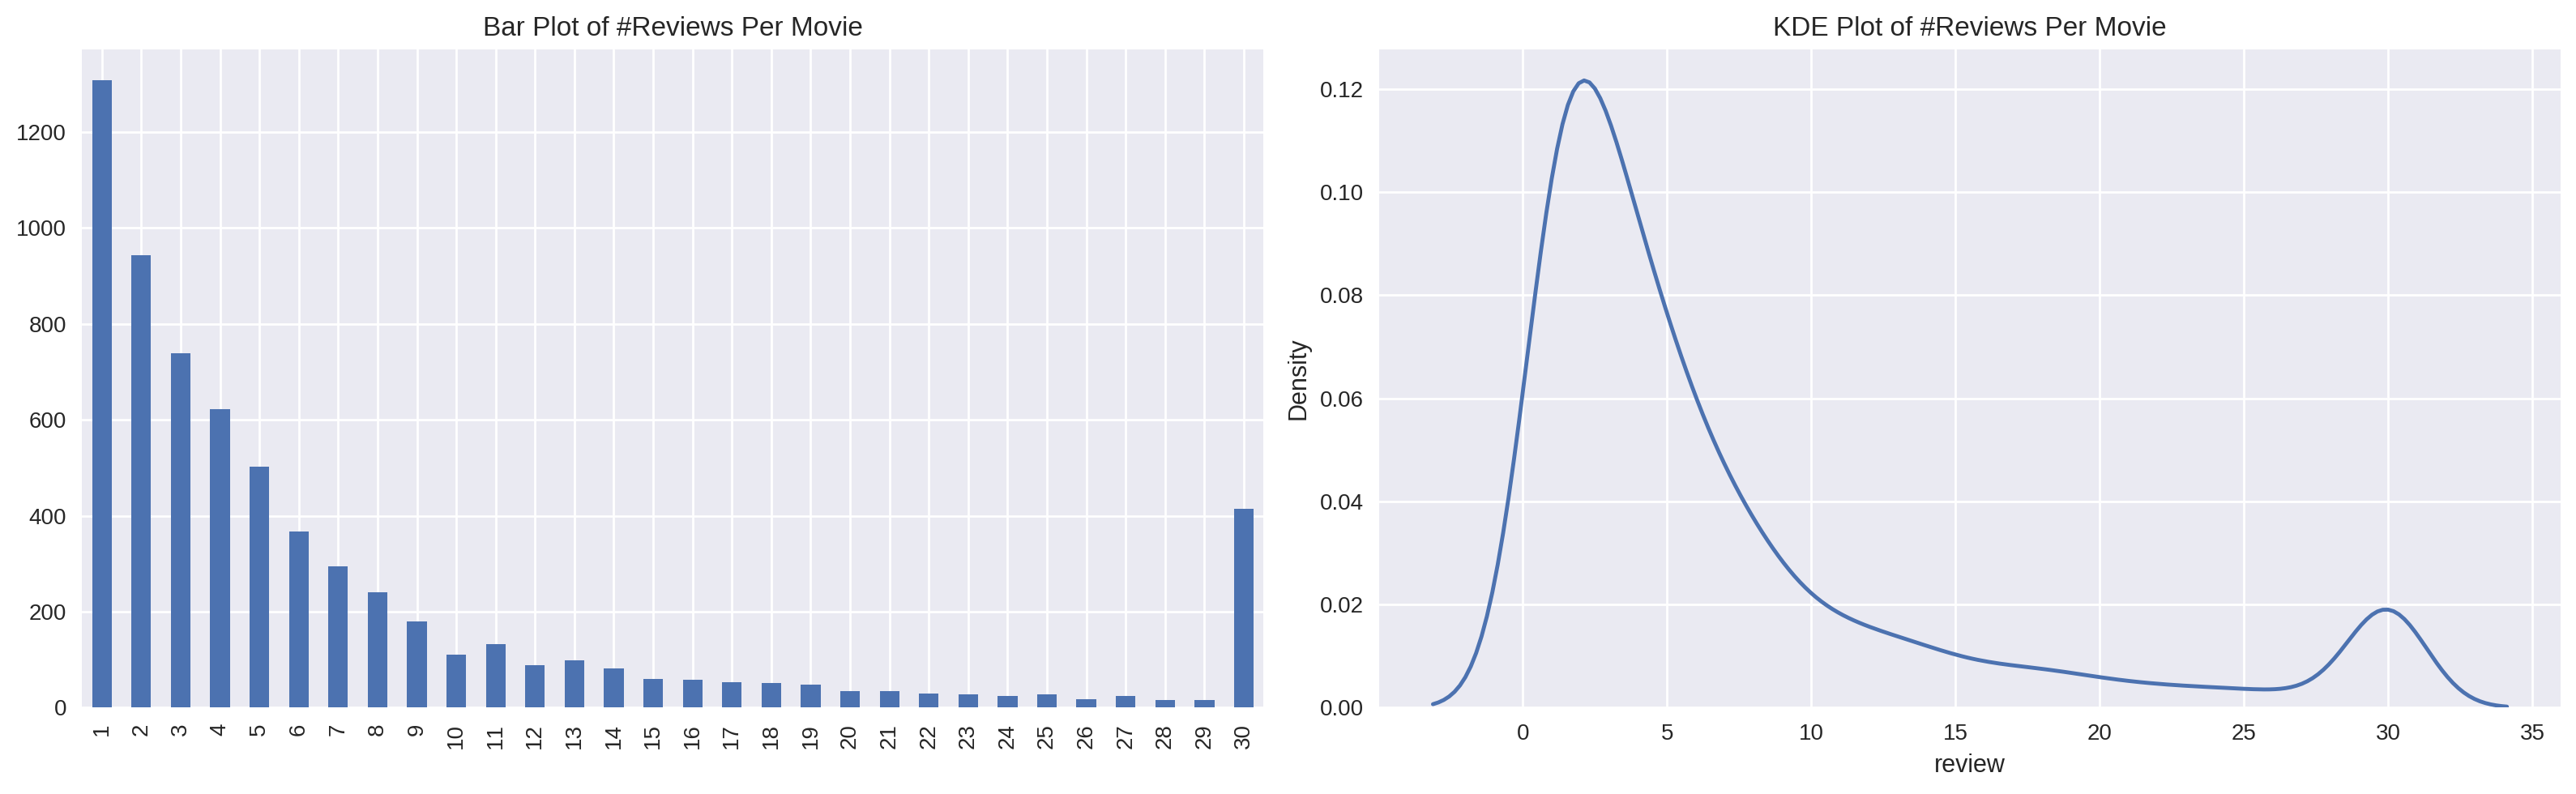

In [13]:
# Check the distribution of number of reviews per movie with the exact counting and KDE

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('t_const')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('t_const')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

**Observations:**

Most movies have very few reviews. In fact, the majority have 6 or fewer reviews, or around 30. However, only a small number of movies have between 9 and 29 reviews.

In [14]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

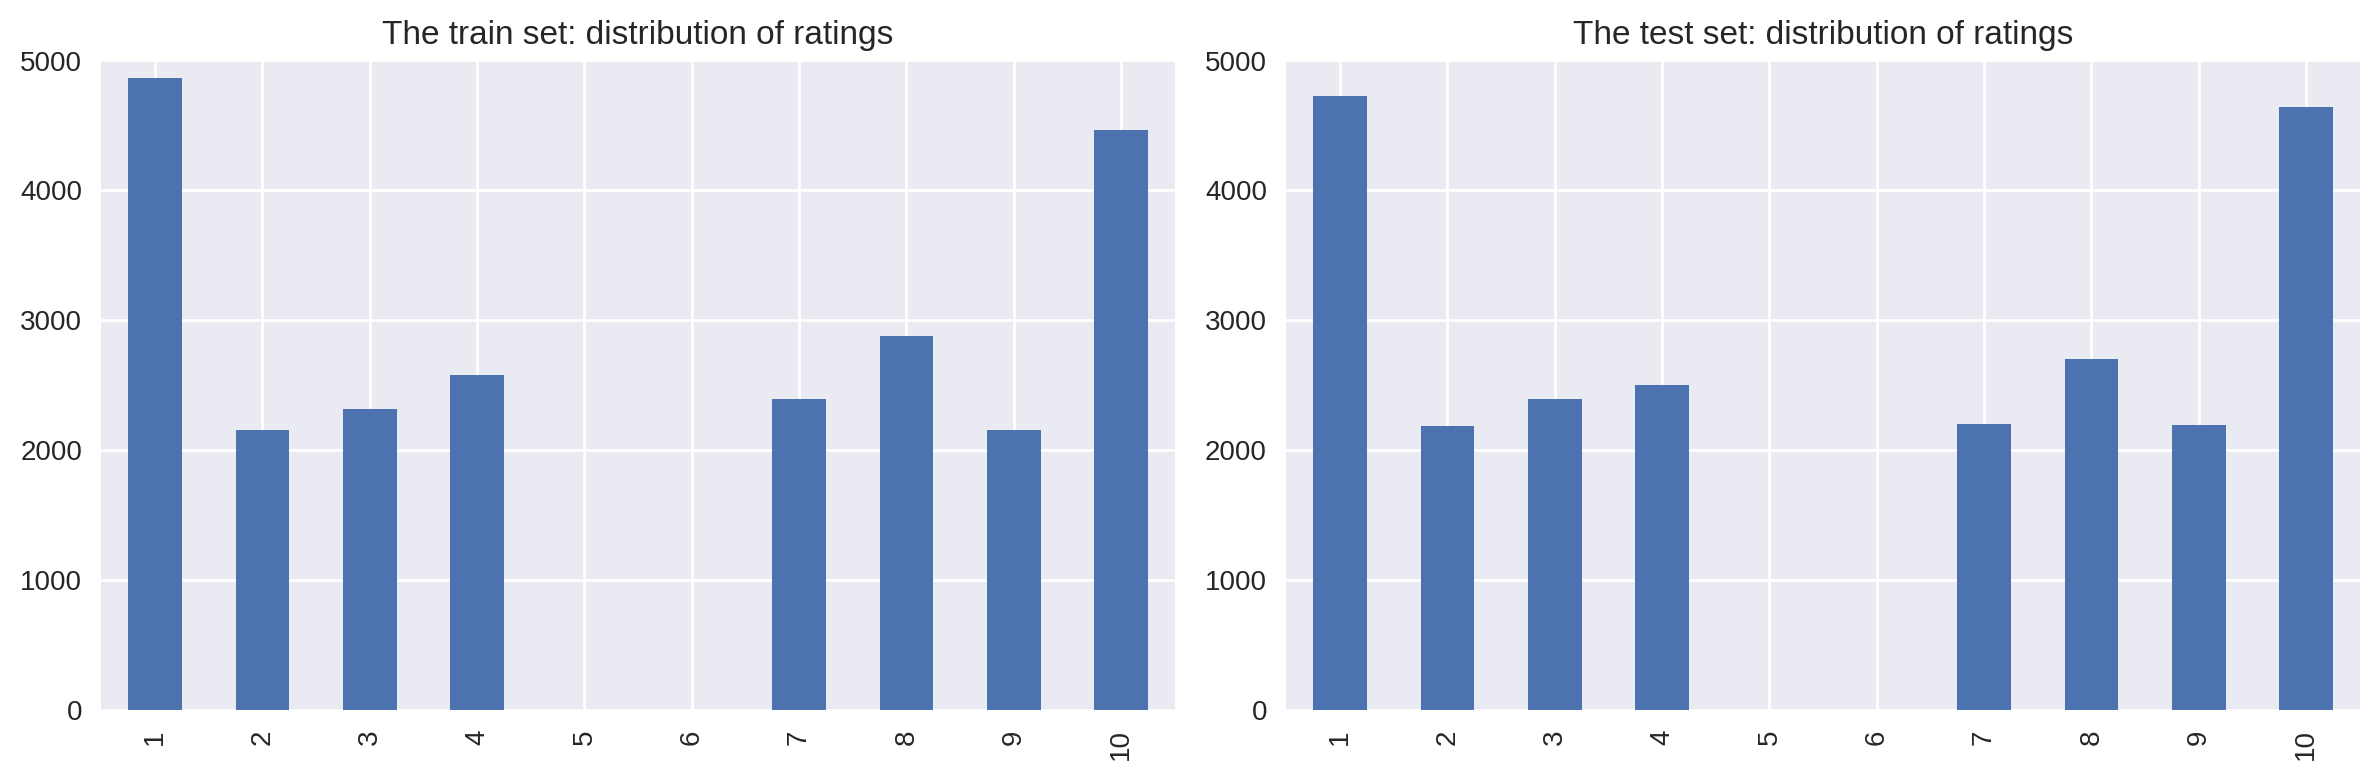

In [15]:
# Distribution of ratings for train and test set

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

**Observations:** Both the train and test sets display a comparable distribution pattern, featuring a notable peak at rating values 1 and 10. Interestingly, there is an absence of data points specifically at rating values 5 and 6.

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


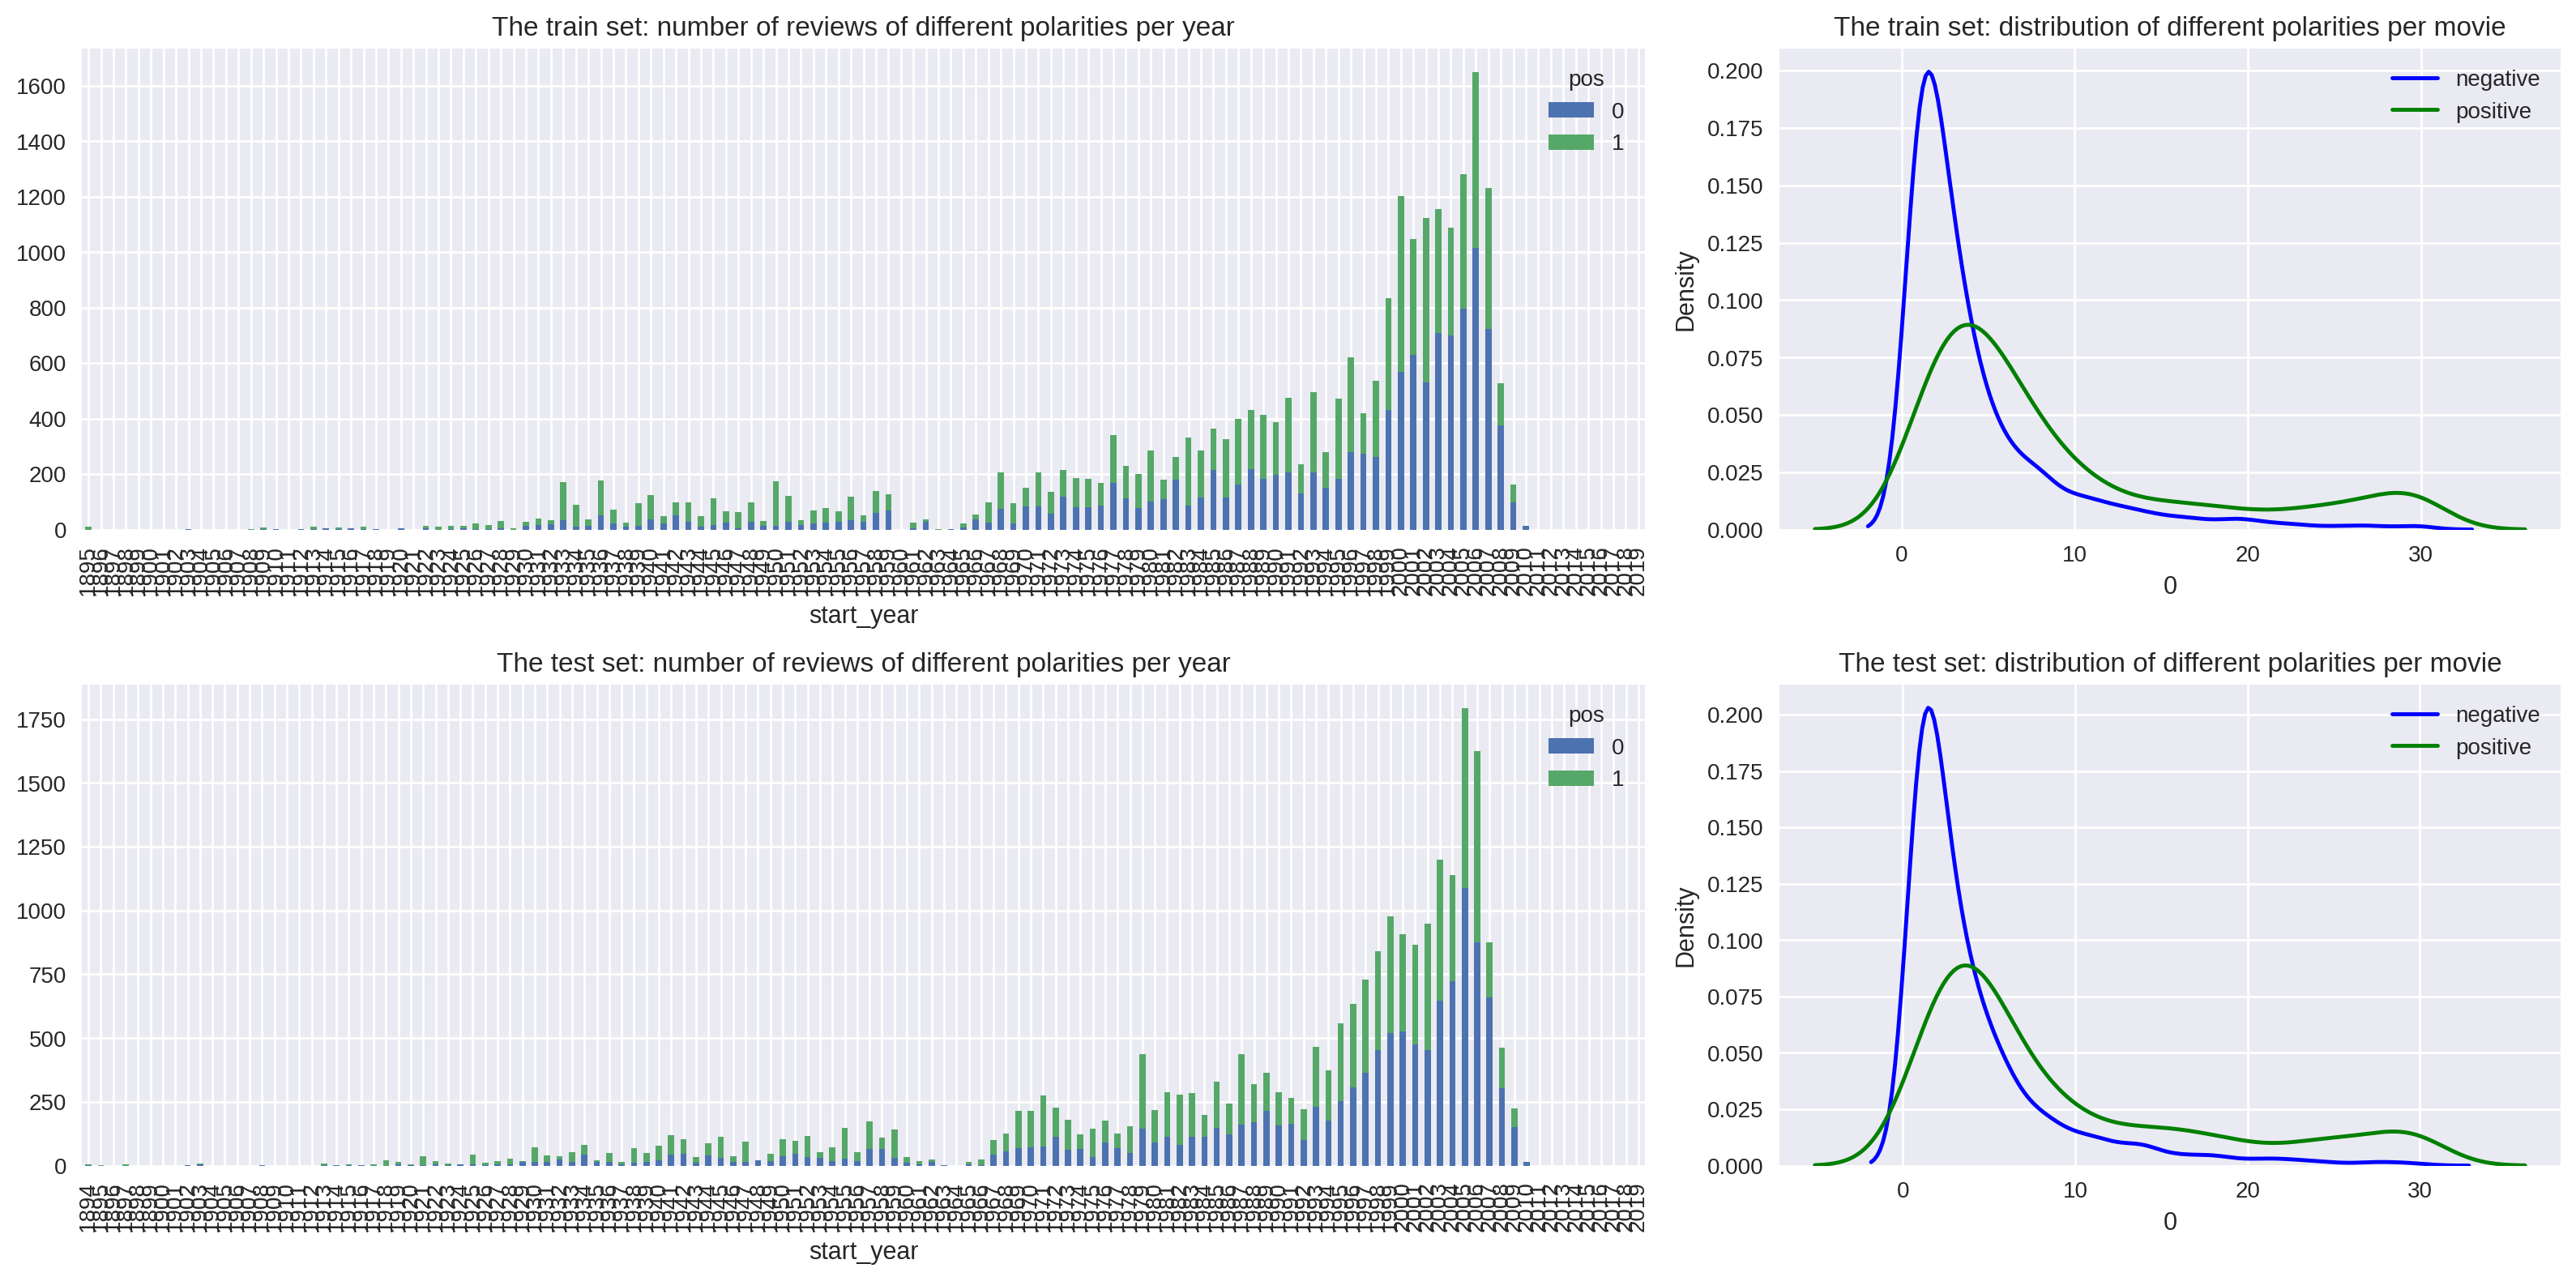

In [16]:
# Distribution of negative and positive reviews over the years for two parts of the dataset

fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['t_const', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['t_const', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

In [17]:
# Compose an evaluation routine which can be used for all models in this project

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

In [18]:
# Function to remove punctuations and digits

def normalize_text(text):
    normalized_text = text.lower()
    normalized_text = re.sub(r'[^a-zA-Z\']', ' ', normalized_text)
    normalized_text = " ".join(normalized_text.split())
    return normalized_text

In [19]:
# Normalize the reviews

df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

In [20]:
# Sample one review to ensure normalization worked accordingly

df_reviews['review_norm'].sample(1)

44051    this is one of the best bloke movies from the early 's and whilst slightly dated its one of those movies that would never get made today which makes it very special in fact a very similar movie was made in the 's called masterminds and it was a pg variation on the same theme but it was nowhere near as fun or realistic for that matter so what's so special about this film it's the comradre between the main characters and the against all odds theme of the film sean astin is very likable and has starred in some of the most memorable films of the 's particularly the goonies he also went onto greater things with rudy and the lord of the rings trilogy but encino man is a good trip down memory lane will wheaton from stand by me lends nice support to the film and andrew divoff is a terrific villain louis gossett jr sleepwalks in his role but he does add some brevity to the film particularly his relationship with astin's rebellious nature so how's the action by today's standards it's ra

## Train / Test Split

In [21]:
# Creating two separate DataFrames (train & test)
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Identifying the targets
y_train = df_reviews_train['pos']
y_test = df_reviews_test['pos']

train_reviews = df_reviews_train['review_norm']
test_reviews = df_reviews_test['review_norm']

print(train_reviews.shape)
print(y_train.shape)

print(test_reviews.shape)
print(y_test.shape)

(23796,)
(23796,)
(23533,)
(23533,)


## Models

### Model 0 - Constant

In [22]:
# Run a dummy model to acquire a baseline

dummy_model = DummyClassifier(strategy='uniform', random_state=950106)
dummy_model.fit(train_reviews, y_train)
pred_dummy = dummy_model.predict(test_reviews)

f1 = metrics.f1_score(y_test, pred_dummy)
print("F1 score:", f1)

F1 score: 0.49819279670025934


**Findings:** The DummyClassifier model's F1 score suggests its performance is comparable to random guessing. However, there is some alignment between the model's predictions and the actual labels.

### Model 1 - NLTK, TF-IDF and LR

In [23]:
# Function to vectorize

def tfidf_vectorizer(train_reviews, test_reviews):
    stop_words = set(stopwords.words('english'))
    count_tf_idf = TfidfVectorizer(stop_words=stop_words)
    
    count_tf_idf.fit(train_reviews)
    
    X_train = count_tf_idf.transform(train_reviews)
    X_test = count_tf_idf.transform(test_reviews)
    
    return X_train, X_test

In [24]:
# Vectorize the features

X_train_1, X_test_1 = tfidf_vectorizer(train_reviews, test_reviews)

In [25]:
# Print shapes

print(X_train_1.shape)
print(X_test_1.shape)

(23796, 71531)
(23533, 71531)


In [26]:
# Create, train and predict with model

model_1 = LogisticRegression(random_state=950106)
model_1.fit(X_train_1, y_train)
pred_model_1 = model_1.predict(X_test_1)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


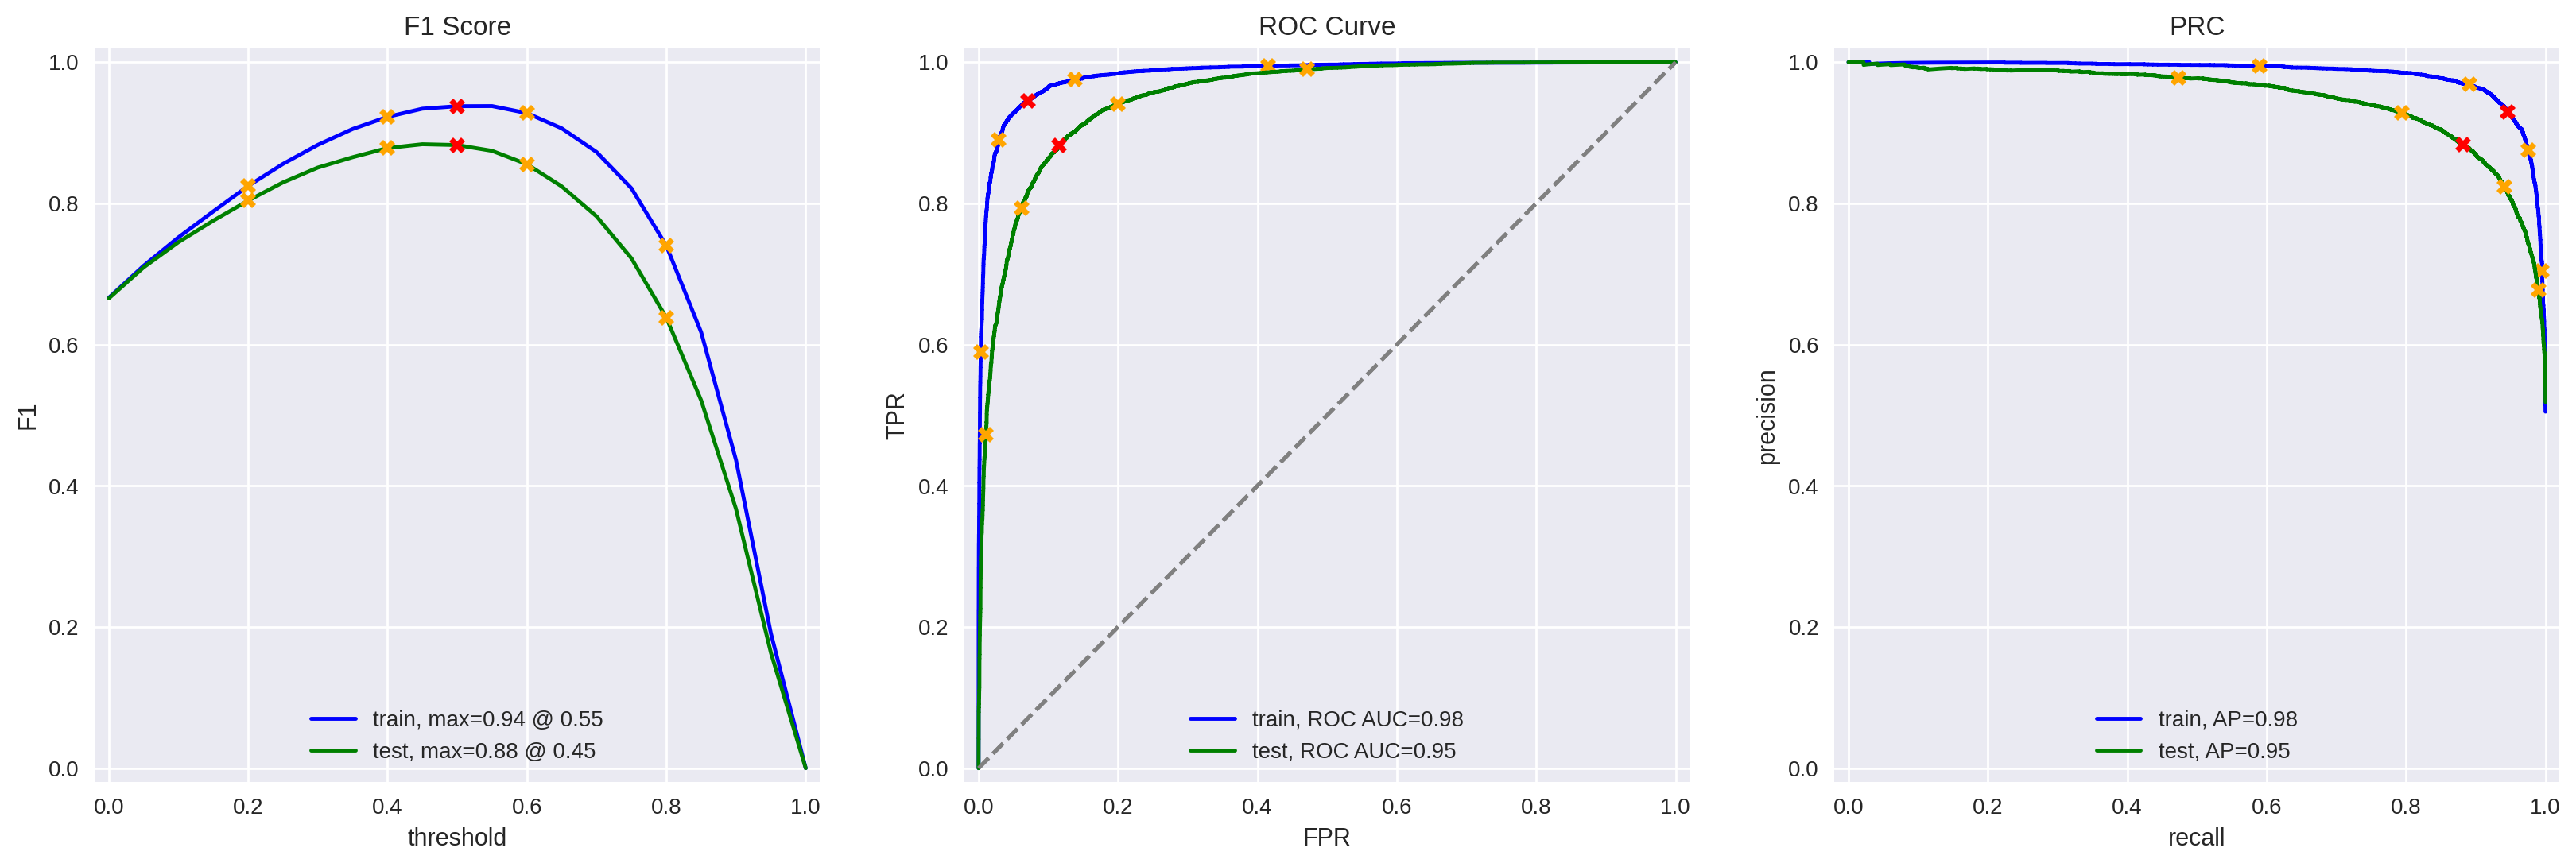

In [27]:
# Evaluate the model

evaluate_model(model_1, X_train_1, y_train, X_test_1, y_test)

**Model 1 Conclusion:** 

The logistic regression model performed well on both the training and test sets, demonstrating strong accuracy, F1 score, APS, and ROC AUC values consistently. Despite its effectiveness in classification, there was a slight drop in performance on the test set relative to the training set, implying potential overfitting.

### Model 3 - spaCy, TF-IDF and LR

In [28]:
# Load the small-size English-language model and disable some components of the pipeline

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [29]:
# Function to lemmatize and tokenize the texts

def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    lemmas_joined = ' '.join(tokens)
    return lemmas_joined

In [30]:
# Apply the pre-processing function to the train set

train_features_lemma = df_reviews_train['review_norm'].apply(text_preprocessing_3)

In [31]:
# Apply the pre-processing function to the test set

test_features_lemma = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [32]:
# Vectorize the features

X_train_3, X_test_3 = tfidf_vectorizer(train_features_lemma, test_features_lemma)

In [33]:
# Create, train and predict with model

model_3 = LogisticRegression(random_state=950106)
model_3.fit(X_train_3, y_train)

LogisticRegression(random_state=950106)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


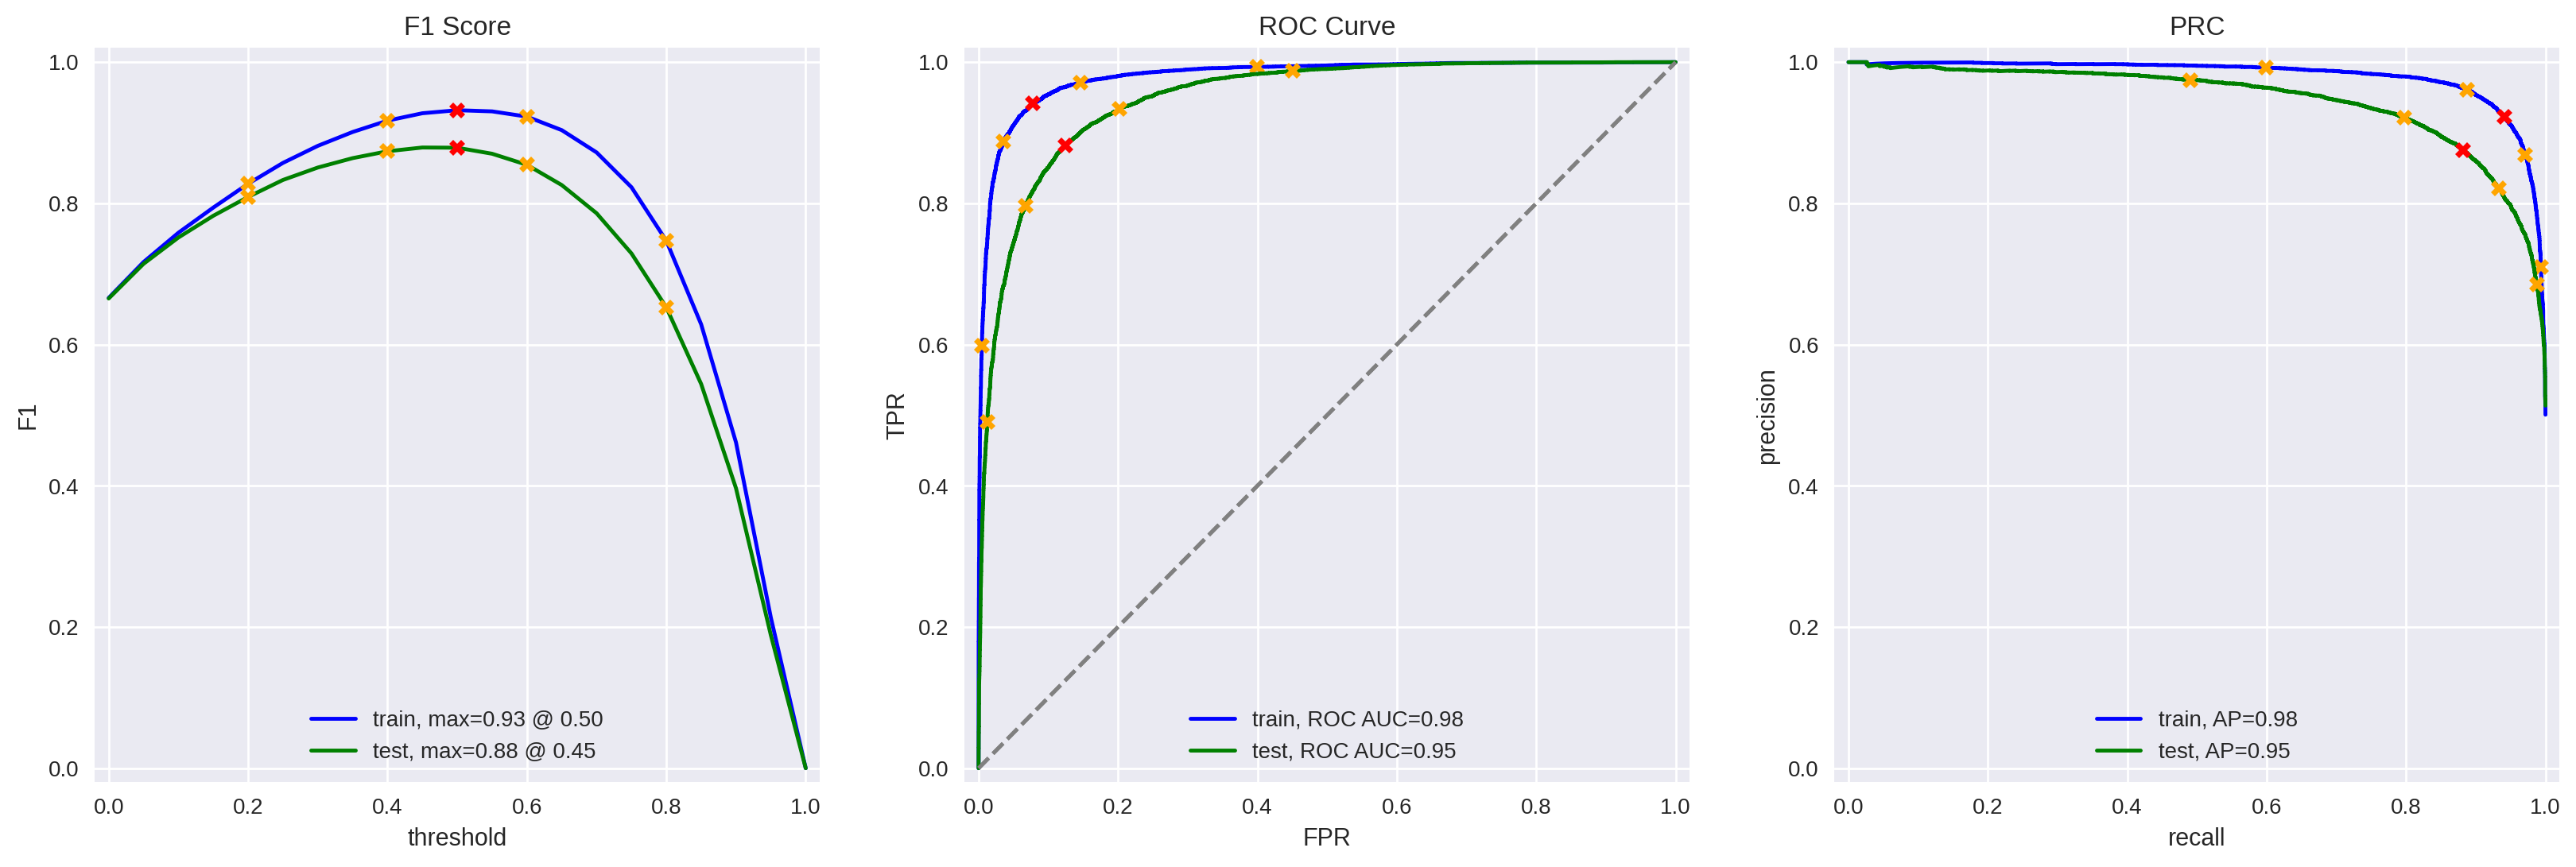

In [34]:
# Evaluate the model

evaluate_model(model_3, X_train_3, y_train, X_test_3, y_test)

**Model 3 Conclusion:**

The logistic regression model demonstrated strong performance on both the training and test datasets. Here are the key metrics:

- Accuracy: 0.93 on the training set and 0.88 on the test set, indicating that the model correctly classified the majority of instances in both datasets.
- F1 Score: 0.93 on the training set and 0.88 on the test set, reflecting a good balance between precision and recall.
- Area Under the Precision-Recall Curve (APS): 0.98 on the training set and 0.95 on the test set, showing excellent discrimination ability.
- Receiver Operating Characteristic Curve (ROC AUC): 0.98 on the training set and 0.95 on the test set, further confirming the model's strong discrimination capability.

These metrics indicate that the logistic regression model effectively captured patterns and made accurate predictions, with good generalization to unseen data.

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [35]:
# Declare features for lgb

X_train_4 = X_train_3.copy()
X_test_4 = X_test_3.copy()

In [36]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 10]
}

# Create the LightGBM model
lgb_model = LGBMClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='f1_macro', cv=3)

# Fit the model
grid_search.fit(X_train_4, y_train)

# Get the best parameters and best accuracy
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

model_4 = best_model

In [37]:
# Fit the best model on the entire training data
model_4.fit(X_train_4, y_train)

LGBMClassifier(max_depth=10, n_estimators=150)

          train  test
Accuracy   0.93  0.85
F1         0.93  0.86
APS        0.98  0.93
ROC AUC    0.98  0.93


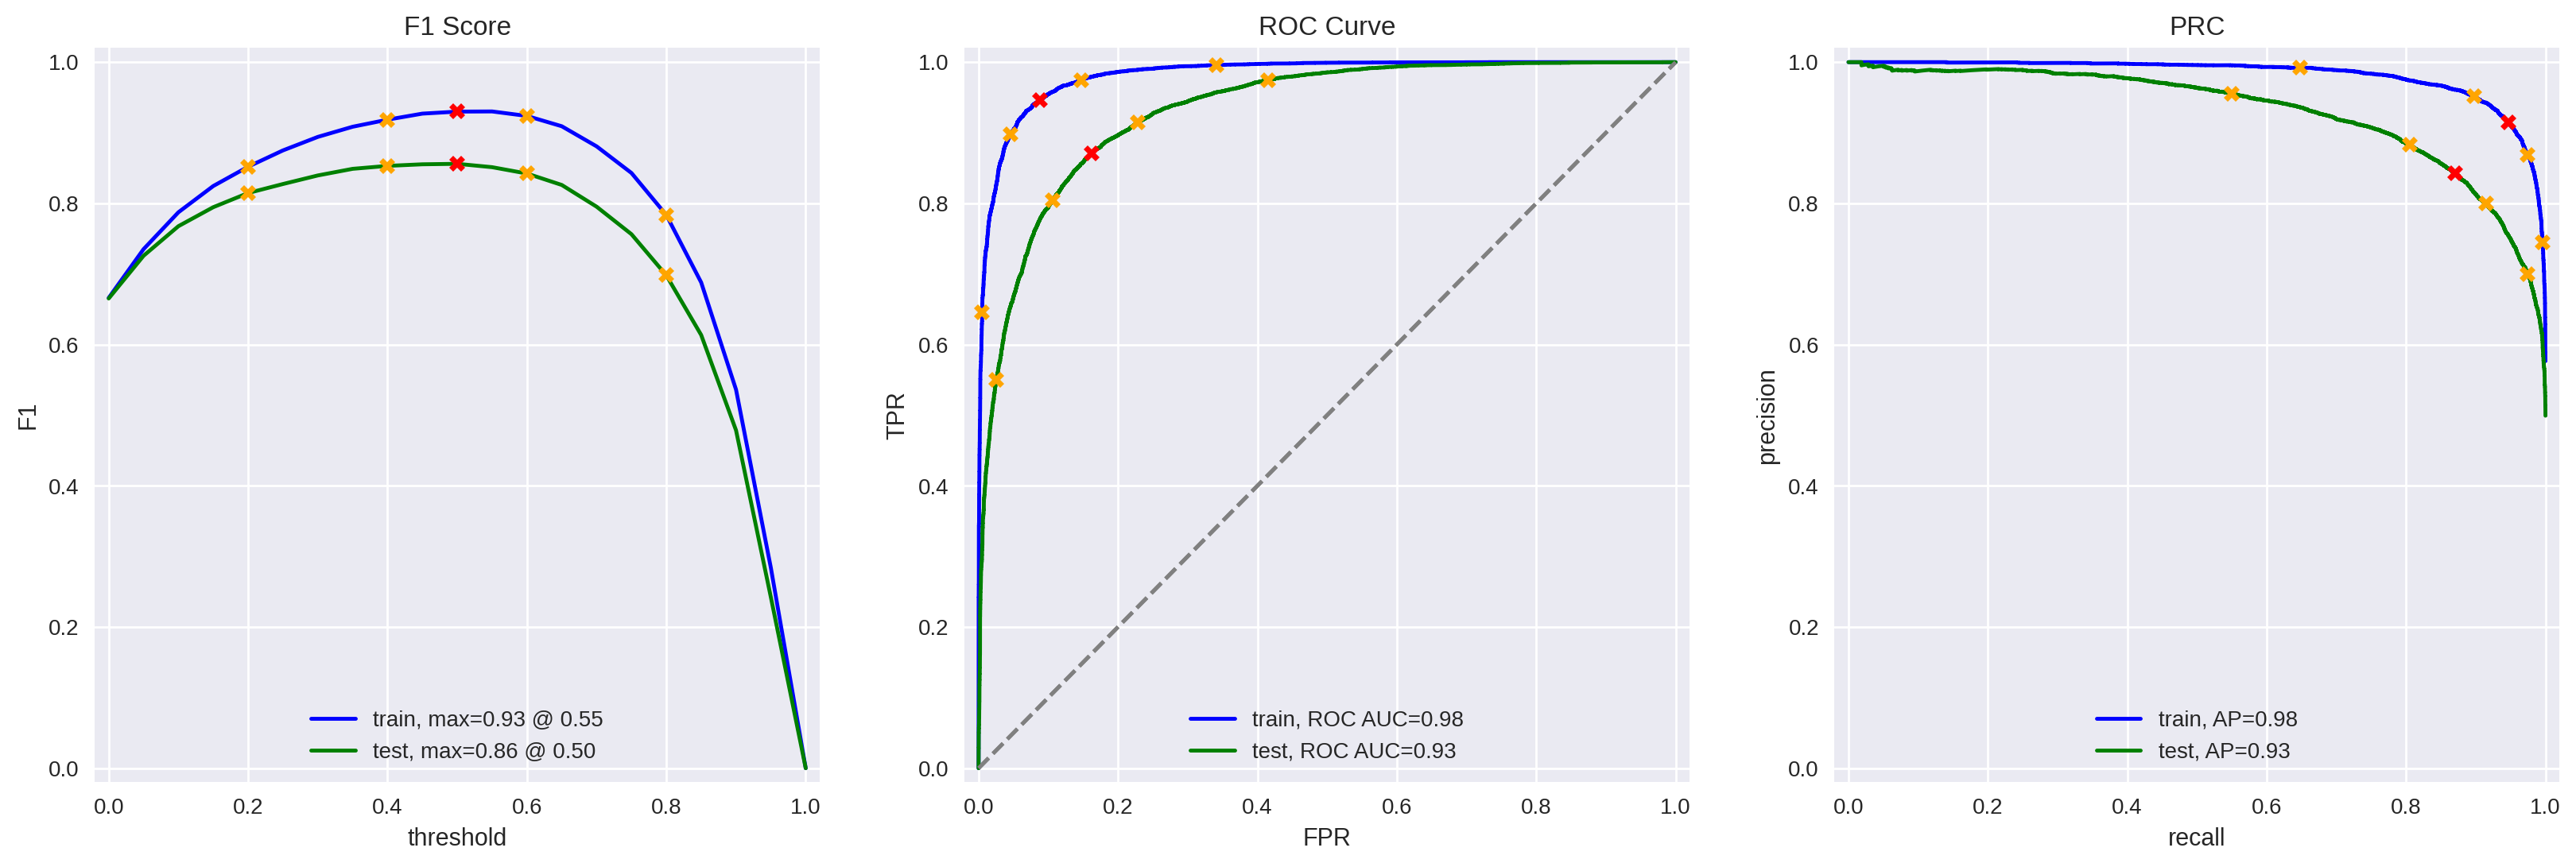

In [38]:
# Evaluate the model

evaluate_model(model_4, X_train_4, y_train, X_test_4, y_test)

**Model 4 Conclusion:**
    
    
The logistic regression model showed strong performance across both training and test datasets. It achieved an accuracy of 0.93 on the training set and 0.85 on the test set, demonstrating effective classification across both datasets. Consistent F1 scores of 0.93 on the training set and 0.86 on the test set highlight balanced precision and recall.

Additionally, the model exhibited excellent discrimination ability, reflected in high area under the precision-recall curve (APS) and receiver operating characteristic curve (ROC AUC). APS values were 0.98 on the training set and 0.93 on the test set, paralleled by ROC AUC values of 0.98 on the training set and 0.93 on the test set.

These findings underscore the logistic regression model's robust performance in identifying patterns and making accurate predictions, underscoring its strong generalization ability on unseen data.

###  Model 9 - BERT

In [39]:
# Initialize BERT model and tokenizer

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
def BERT_text_to_embeddings(texts, max_sample_size=200, max_length=512, batch_size=50, force_device=None, disable_progress_bar=False):
    texts_list = texts.iloc[:max_sample_size].tolist()  

    encodings = tokenizer(texts_list, truncation=True, padding=True, max_length=512, return_tensors='pt')

    ids_list = encodings['input_ids']
    attention_mask_list = encodings['attention_mask']

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')

    dataset = TensorDataset(ids_list, attention_mask_list)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    embeddings = []

    for batch in tqdm(dataloader, disable=disable_progress_bar):
        ids_batch, attention_mask_batch = batch
        ids_batch = ids_batch.to(device)
        attention_mask_batch = attention_mask_batch.to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [ ]:
# Embed the train reviews
X_train_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cpu')

# Embed the test reviews
X_test_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cpu')

In [ ]:
print(f"X_train_9 shape: {X_train_9.shape}")
print(f"X_test_9 shape: {X_test_9.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

In [ ]:
# Save the embeddings
np.savez_compressed('features_9.npz', X_train_9=X_train_9, X_test_9=X_test_9)

# Load the embeddings
with np.load('features_9.npz') as data:
    X_train_9 = data['X_train_9']
    X_test_9 = data['X_test_9']

In [ ]:
model_9 = LogisticRegression(random_state=950106)
model_9.fit(X_train_9, y_train)

evaluate_model(model_9, X_train_9, y_train_small, X_test_9, y_test_small)

**Model 9 Conclusions:** Unfortunately, my M1 MacBook Pro imposes limitations that prevent me from embedding text using BERT. The kernel crashes when I attempt to use sizes larger than 5 for both max_sample_size and batch_size. Consequently, I am unable to conduct an analysis on the performance of the BERT model.

## My Reviews

In [41]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middle of the movie.",well i was bored and felt asleep in the middle of the movie
2,I was really fascinated with the movie,i was really fascinated with the movie
3,"Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.",even the actors looked really old and disinterested and they got paid to be in the movie what a soulless cash grab
4,I didn't expect the reboot to be so good! Writers really cared about the source material,i didn't expect the reboot to be so good writers really cared about the source material
5,"The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.",the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myself going to see it again
6,"What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!",what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids won't like this
7,"Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.",launching on netflix was a brave move i really appreciate being able to binge on episode after episode of this exciting intelligent new drama


### Model 1

In [42]:
train_reviews = df_reviews_train['review_norm']
train_labels = df_reviews_train['pos']

In [43]:
def tfidf_vectorizer(train_reviews):
    stop_words = set(stopwords.words('english'))
    count_tf_idf = TfidfVectorizer(stop_words=stop_words)

    count_tf_idf.fit(train_reviews)
    X_train = count_tf_idf.transform(train_reviews)

    return X_train, count_tf_idf

In [ ]:
# Fit the vectorizer on train reviews
X_train, count_tf_idf = tfidf_vectorizer(train_reviews)

# Train the model on the transformed train reviews
model_1 = LogisticRegression()
model_1.fit(X_train, train_labels)

texts = my_reviews['review_norm']

# Transform the new reviews using the previously fitted vectorizer
X_my_reviews = count_tf_idf.transform(texts)

# Predict probabilities for the new reviews
my_reviews_pred_prob = model_1.predict_proba(X_my_reviews)[:, 1]

# Print the results
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 3

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_3 = TfidfVectorizer(stop_words=set(stopwords.words('english')))
X_train_3 = tfidf_vectorizer_3.fit_transform(train_reviews)

model_3 = LogisticRegression()
model_3.fit(X_train_3, train_labels)

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
model_4 = LogisticRegression()
model_4.fit(X_train_3, train_labels)

my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 9

In [ ]:
# texts = my_reviews['review_norm']
# my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)
# my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]
# for i, review in enumerate(texts.str.slice(0, 100)):
#     print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

**Note:** As mentioned earlier, due to restrictions, the BERT model is not being used in this project.

## Conclusions

Overall Conclusion:

The Film Junky Union's initiative to develop a system for filtering and categorizing movie reviews through automated detection of negative reviews has shown promising results. Among the models evaluated using the IMDB movie reviews dataset, the logistic regression models demonstrated strong and consistent performance across various metrics. These included accuracy, F1 score, Area Under the Precision-Recall Curve (APS), and Receiver Operating Characteristic Curve (ROC AUC).

Key insights from the evaluations include:

- Model 1: Displayed high accuracy and strong performance metrics, but a slight drop in the test set performance suggested potential overfitting.
- Model 3: Achieved an accuracy of 0.93 on the training set and 0.88 on the test set, with F1 scores of 0.93 and 0.88 respectively. APS and ROC AUC values were notably high, indicating the model's robust discrimination capability.
- Model 4: Showed balanced performance with an accuracy of 0.93 on the training set and 0.85 on the test set. F1 scores were consistent at 0.93 and 0.86, and both APS and ROC AUC values were high, confirming the model's strong generalization to unseen data.
- Model 9: Due to technical limitations on the user's M1 MacBook Pro, the analysis of the BERT model could not be completed.

Additionally, when using the model to predict new reviews, all three logistic regression models were relatively successful at identifying reviews as either negative (0) or positive (1). They were able to tag new reviews appropriately, demonstrating their practical applicability and reliability.

Overall, the logistic regression models demonstrated their efficacy in identifying patterns and making accurate predictions, meeting the project's goal with an F1 score of at least 0.85. Despite the limitations faced with the BERT model, the logistic regression models provide a reliable foundation for the Film Junky Union's system, effectively categorizing movie reviews with high precision and recall.